In [1]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
train_path = r'E:\Dataset\train'
test_path = r'E:\Dataset\test'
model_save_path = r'E:\Skin Disease Classification\ResNet50_modelv32.h5'

In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)


Found 5920 images belonging to 6 classes.
Found 1479 images belonging to 6 classes.


In [28]:
class_indices = train_generator.class_indices
classes = list(class_indices.keys())
print("Classes:", classes)

Classes: ['Acne and Rosacea Photos', 'Atopic Dermatitis Photos', 'Basal Cell Carcinoma (BCC)', 'Benign Keratosis-like Lesions (BKL)', 'Melanocytic Nevi (NV)', 'Nail Fungus and other Nail Disease']


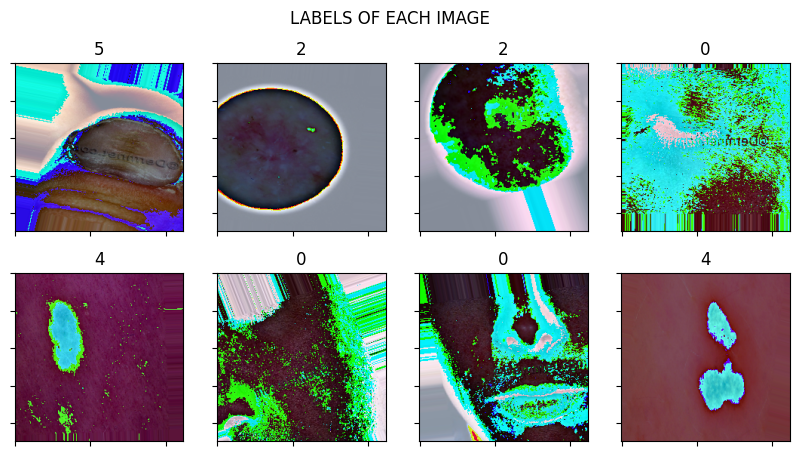

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for ax in axes.flatten():
    img, label = train_generator.next()
    img = img[0]  
    label = np.argmax(label[0]) 
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(False)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2RGB))

plt.show()

In [19]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
num_classes = len(train_generator.class_indices)
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(216, activation='relu')(x)
x = Dropout(0.5)(x) 
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [20]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/20
370/370 [==============================] - 198s 526ms/step - loss: 0.7885 - accuracy: 0.6780 - val_loss: 0.7576 - val_accuracy: 0.6809 - lr: 0.0010
Epoch 2/20
370/370 [==============================] - 167s 452ms/step - loss: 0.6180 - accuracy: 0.7490 - val_loss: 0.6347 - val_accuracy: 0.7302 - lr: 0.0010
Epoch 3/20
370/370 [==============================] - 177s 479ms/step - loss: 0.5652 - accuracy: 0.7694 - val_loss: 0.7172 - val_accuracy: 0.7275 - lr: 0.0010
Epoch 4/20
370/370 [==============================] - 160s 433ms/step - loss: 0.5282 - accuracy: 0.7792 - val_loss: 0.6487 - val_accuracy: 0.7505 - lr: 0.0010
Epoch 5/20
370/370 [==============================] - 159s 429ms/step - loss: 0.4968 - accuracy: 0.7919 - val_loss: 0.6592 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 6/20
370/370 [==============================] - 189s 510ms/step - loss: 0.4279 - accuracy: 0.8230 - val_loss: 0.6018 - val_accuracy: 0.7613 - lr: 2.0000e-04
Epoch 7/20
370/370 [======================

In [22]:
model.save(model_save_path)

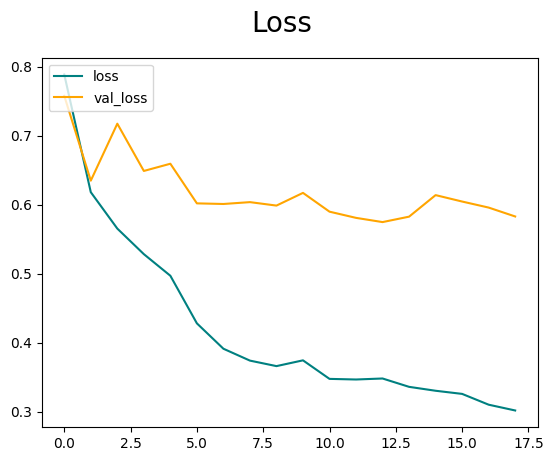

In [23]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

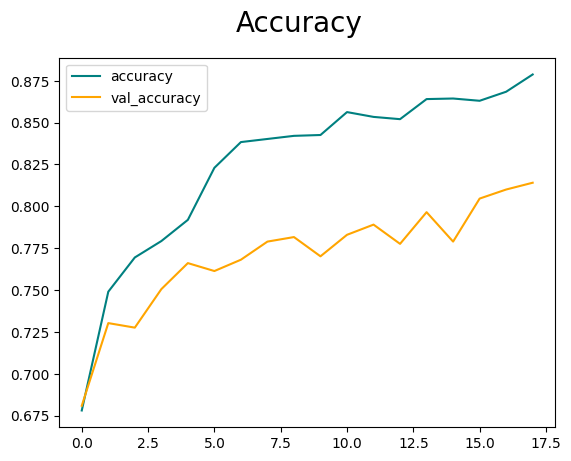

In [24]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [25]:
# Load the model
model = load_model(model_save_path)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())



Found 3352 images belonging to 6 classes.
105/105 [==============================] - 30s 280ms/step


In [26]:
print(classification_report(true_labels, predicted_classes, target_names=class_labels))

# Print confusion matrix
print(confusion_matrix(true_labels, predicted_classes))


                                     precision    recall  f1-score   support

            Acne and Rosacea Photos       0.79      0.94      0.86       312
           Atopic Dermatitis Photos       0.91      0.83      0.87       501
         Basal Cell Carcinoma (BCC)       0.86      0.86      0.86       613
Benign Keratosis-like Lesions (BKL)       0.66      0.72      0.69       480
              Melanocytic Nevi (NV)       0.95      0.89      0.92      1185
 Nail Fungus and other Nail Disease       0.84      0.87      0.85       261

                           accuracy                           0.86      3352
                          macro avg       0.84      0.85      0.84      3352
                       weighted avg       0.86      0.86      0.86      3352

[[ 294   12    0    0    0    6]
 [  46  416    3    2    3   31]
 [   0    0  525   83    5    0]
 [   0    0   80  347   53    0]
 [  20    6    4   90 1060    5]
 [  11   24    0    0    0  226]]


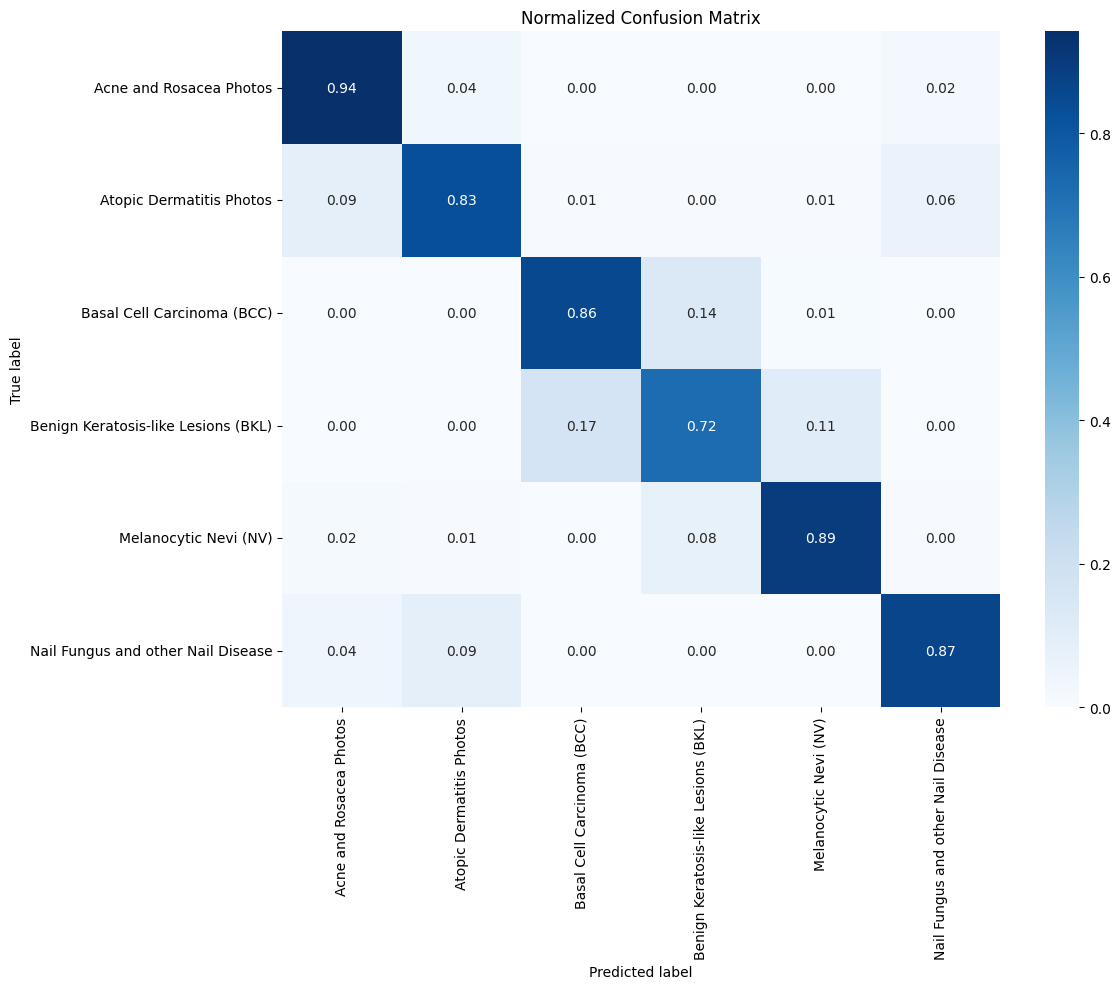

In [27]:
def plot_confusion_matrix(y_true, y_pred, class_names):
  
    cm = confusion_matrix(y_true, y_pred)
    
   
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix')
    
    plt.tight_layout()
    plt.show()

class_labels = list(test_generator.class_indices.keys())
plot_confusion_matrix(true_labels, predicted_classes, class_labels)

In [5]:
image_path = r'E:\Dataset\test\Basal Cell Carcinoma (BCC)\ISIC_0056124.jpg'

if not os.path.isfile(image_path):
    raise FileNotFoundError(f"The file at {image_path} does not exist.")

# Load and preprocess the image
img = load_img(image_path, target_size=(224, 224)) 
img_array = img_to_array(img)  
img_array = np.expand_dims(img_array, axis=0)  
img_array = preprocess_input(img_array) 
predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions, axis=1)[0]

class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

predicted_class_name = class_names[predicted_class_index]

print(f'The model predicts that the image belongs to class: {predicted_class_name}')

1/1 [==============================] - 3s 3s/step
The model predicts that the image belongs to class: Benign Keratosis-like Lesions (BKL)
